In [20]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('data/t2e/text_train.csv')
df = df.append(pd.read_csv('data/t2e/text_test.csv'))
display(df.head())

,wav_file,label,transcription
0,Ses03M_script01_1_M017,5,you know why i asked annie here right ?
1,Ses01F_script03_2_F018,0,you shut up .
2,Ses01F_script01_3_F028,5,yeah sure .
3,Ses02F_impro05_F003,4,how do you lose a suitcase ? a huge suitcase ?
4,Ses04F_script03_2_F043,0,oh i hate you . it s a good thing that i found...


In [21]:
col = ['label', 'transcription']
df = df[col]

In [22]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [23]:
df.columns = ['label', 'transcription']

In [24]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

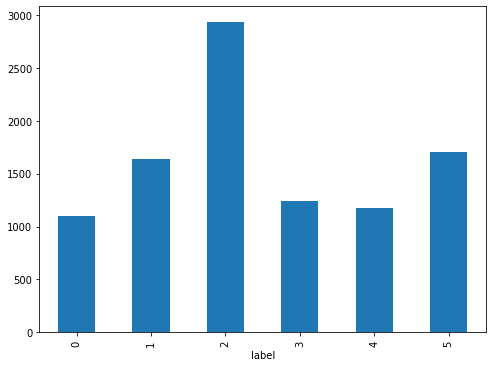

In [25]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [26]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(9797, 2464)


In [27]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [28]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.606
Test Set F-score =  0.599
Test Set Precision =  0.635
Test Set Recall =  0.613
Confusion matrix, without normalization
[[ 88   7  93  21  16  18]
 [  4 171 100  23  12  33]
 [ 27  23 382  54  18  48]
 [  0   0   0 258   0   0]
 [  0   0   0  47 174   0]
 [ 11  33 143  22  19 115]]


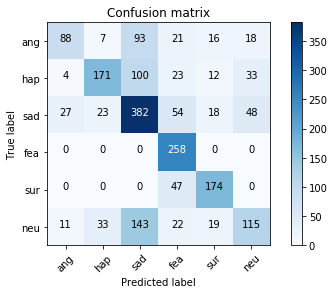

In [29]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

/opt/conda/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:18:59] WARNING: ../src/learner.cc:573: 
Parameters: { "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:19:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

In [ ]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [18]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.        , 0.        , 0.00237196, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [19]:
with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)
    
display_results(y_test, lstm_pred_probs)

FileNotFoundError: [Errno 2] No such file or directory: 'pred_probas/text_lstm_classifier.pkl'

In [ ]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

In [ ]:
top_n = [500, 1000, 1500, 2000]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=600, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)